In [242]:
import pandas as pd
import numpy as np
import seaborn as sns
import cPickle as pickle
import codecs

from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.cluster.bicluster import SpectralCoclustering
from biclustering.biclustering import DeltaBiclustering
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.metrics.cluster import adjusted_rand_score

In [243]:
%matplotlib inline
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})

In [244]:
def generate_dataset(option, noise=1, noise_background=True, shuffle=False):
    shape = (150,150)
    n,m = shape
    
    # values can't be a lot far...
    centers = [20, 40, 60, 80, 100]
    
    y_row = np.zeros(150)
    y_col = np.zeros(150)

    if noise_background:
        data = np.random.rand(n, m)*100
    else:
        data = np.zeros(n*m).reshape(shape)

    if option == 'a':
        data[60:110][:,70:140] = np.random.rand(50,70)*noise + centers[0]
        y_row[60:110] += 1
        y_col[70:140] += 1
    elif option == 'd':
        data[0:50][:,0:70] = np.random.rand(50,70)*noise + centers[0]
        y_row[0:50] += 1
        y_col[0:70] += 1

        data[50:100][:,50:100] = np.random.rand(50,50)*noise + centers[2]
        y_row[50:100] += 2
        y_col[50:100] += 2

        data[100:150][:,80:150] = np.random.rand(50,70)*noise + centers[1]
        y_row[100:150] += 3
        y_col[80:150] += 3
    elif option == 'e':
        data[0:70][:,0:50] = np.random.rand(70,50)*noise + centers[3]
        y_row[0:70] += 1
        y_col[0:50] += 1

        data[50:100][:,50:100] = np.random.rand(50,50)*noise + centers[1]
        y_row[50:100] += 2
        y_col[50:100] += 2

        data[80:150][:,100:150] = np.random.rand(70,50)*noise + centers[2]
        y_row[80:150] += 3
        y_col[100:150] += 3
    elif option == 'f':
        data[0:50][:,0:40] = np.random.rand(50,40)*noise + centers[4]
        y_row[0:50] += 1
        y_col[0:40] += 1

        data[50:150][:,0:40] = np.random.rand(100,40)*noise + centers[0]
        y_row[50:150] += 2

        data[110:150][:,40:95] = np.random.rand(40,55)*noise + centers[2]
        y_row[110:150] += 3
        y_col[40:95] += 2

        data[110:150][:,95:150] = np.random.rand(40,55)*noise + centers[1]
        y_row[110:150] += 3
        y_col[95:150] += 3
    elif option == 'g':
        data[0:110][:,0:40] = np.random.rand(110,40)*noise + centers[0]
        data[110:150][:,0:110] = np.random.rand(40,110)*noise + centers[2]
        data[40:150][:,110:150] = np.random.rand(110,40)*noise + centers[1]
        data[0:40][:,40:150] = np.random.rand(40,110)*noise + centers[3]
    elif option == 'h':
        data[0:90][:,0:90] = np.random.rand(90,90)*noise + centers[0]
        data[35:55][:,35:55] = (np.random.rand(20,20)*noise + centers[1]) + data[35:55][:,35:55]
        data[110:140][:,35:90] = np.random.rand(30,55)*noise + centers[4]
        data[0:140][:,110:150] = np.random.rand(140,40)*noise + centers[2]
        data[0:55][:,130:150] = (np.random.rand(55,20)*noise + centers[3]) + data[0:55][:,130:150]
    elif option == 'i':
        data[20:70][:,20:70] = np.random.rand(50,50)*noise + centers[0]
        data[20:70][:,100:150] = np.random.rand(50,50)*noise + centers[1]
        data[50:110][:,50:120] = np.random.rand(60,70)*noise + centers[2]
        data[120:150][:,20:100] = np.random.rand(30,80)*noise + centers[3]

    if shuffle:
        np.random.shuffle(data)
        np.random.shuffle(data.T)

    return data, y_row, y_col

In [392]:
def is_any_clust_empty(U_bin):
    n, k = U_bin.shape
    return np.count_nonzero(np.sum(U_bin, axis=0)) != k

def overlapping_matrix_factorization_coclustering(X, k, l, norm=False, num_iters=100):
    n, m = X.shape
    U = np.random.rand(n, k)
    S = np.random.rand(k, l)
    V = []
    for i in xrange(k):
        V.append(np.random.rand(l, m))

    Ii = np.zeros((k, k))
    Ij = np.zeros((k, k))

    error_best = np.inf
    
    if norm:
        X = Normalizer().fit_transform(X)

    V_tilde = np.zeros((k, m))
    for i in xrange(k):
        Ii[i, i] = 1
        V_tilde += Ii.dot(S).dot(V[i])
        Ii[i, i] = 0
    error = np.sum((X - U.dot(V_tilde)) ** 2)

    for _ in xrange(num_iters):
        # Update U
        new_U_pos = np.zeros((n, k))
        new_U_neg = np.zeros((n, k))
        for i in xrange(k):
            Ii[i, i] = 1
            for j in xrange(k):
                Ij[j, j] = 1
                new_U_pos += U.dot(Ii).dot(S).dot(V[i]).dot(V[j].T).dot(S.T).dot(Ij)
                Ij[j, j] = 0
            new_U_neg += X.dot(V[i].T).dot(S.T).dot(Ii)
            Ii[i, i] = 0
        U = U * (new_U_neg / new_U_pos)

        # Compute V'
        V_tilde = np.zeros((k, m))
        for i in xrange(k):
            Ii[i, i] = 1
            V_tilde += Ii.dot(S).dot(V[i])
            Ii[i, i] = 0

        # Compute U binary
        U_bin = np.zeros(U.shape)
        rows_inds = np.argmax(U, axis=1)
        for i in xrange(n):
             U_bin[i, rows_inds[i]] = 1

        # update U so that clusters are orthogonal
        while is_any_clust_empty(U_bin):
            erros = (X - U.dot(V_tilde)) ** 2
            erros = np.sum(U.T.dot(erros), axis=1) / np.sum(U, axis=0)
            erros[np.where(np.sum(U_bin, axis=0) <= 1)] = -np.inf
            quantidade = np.sum(U_bin, axis=0)
            indexMin = np.argmin(quantidade)
            indexMax = np.argmax(erros)
            indexes = np.nonzero(U_bin[:, indexMax])[0]

            end = len(indexes)
            indexes_p = np.random.permutation(end)
            aux = U[indexes[indexes_p[0:np.floor(end/2.0)]], indexMax]
            U[indexes[indexes_p[0:np.floor(end/2.0)]], indexMax] = U[indexes[indexes_p[0:np.floor(end/2.0)]], indexMin]
            U[indexes[indexes_p[0:np.floor(end/2.0)]], indexMin] = aux

            # Recompute U binary for each iteration
            U_bin = np.zeros(U.shape)
            rows_inds = np.argmax(U, axis=1)
            for i in xrange(n):
                U_bin[i, rows_inds[i]] = 1

        # Update Vi
        for i in xrange(k):
            Ii[i, i] = 1
            V[i] = V[i] * ( (S.T.dot(Ii).dot(U.T).dot(X)) / (S.T.dot(Ii).dot(U.T).dot(U).dot(Ii).dot(S).dot(V[i])) )
            Ii[i, i] = 0

        # Recompute V'
        V_tilde = np.zeros((k, m))
        for i in xrange(k):
            Ii[i, i] = 1
            V_tilde += Ii.dot(S).dot(V[i])
            Ii[i, i] = 0

        # Compute Vs binary
        V_bin = []
        for i in xrange(k):
            Vi_bin = np.zeros((l, m))
            cols_inds = np.argmax(V[i], axis=0)
            for j in xrange(m):
                 Vi_bin[cols_inds[j], j] = 1
            V_bin.append(Vi_bin)

        # Update Vs so that clusters are orthogonal
        for i in xrange(k):
            while is_any_clust_empty(V_bin[i].T):
                erros = (X - U.dot(V_tilde)) ** 2
                erros = np.sum(erros.dot(V[i].T), axis=0) / np.sum(V[i], axis=1)
                erros[np.where(np.sum(V_bin[i], axis=1) <= 1)] = -np.inf
                quantidade = np.sum(V_bin[i], axis=1)
                indexMin = np.argmin(quantidade)
                indexMax = np.argmax(erros)
                indexes = np.nonzero(V_bin[i][indexMax, :])[0]

                for j in indexes:
                    if np.random.rand(1) > 0.5:
                        aux = V[i][indexMax, j]
                        V[i][indexMax, j] = V[i][indexMin, j]
                        V[i][indexMin, j] = aux

                # Recompute Vs binary
                V_bin = []
                for ii in xrange(k):
                    Vi_bin = np.zeros((l, m))
                    cols_inds = np.argmax(V[ii], axis=0)
                    for j in xrange(m):
                         Vi_bin[cols_inds[j], j] = 1
                    V_bin.append(Vi_bin)

                # Recompute V'
                V_tilde = np.zeros((k, m))
                for i in xrange(k):
                    Ii[i, i] = 1
                    V_tilde += Ii.dot(S).dot(V[i])
                    Ii[i, i] = 0
            
        new_S_pos = np.zeros((k, l))
        new_S_neg = np.zeros((k, l))
        for i in xrange(k):
            Ii[i, i] = 1
            for j in xrange(k):
                Ij[j, j] = 1
                new_S_pos += Ii.dot(U.T).dot(U).dot(Ij).dot(S).dot(V[j]).dot(V[i].T)
                Ij[j, j] = 0
            new_S_neg += Ii.dot(U.T).dot(X).dot(V[i].T)
            Ii[i, i] = 0
        S = S * (new_S_neg / new_S_pos)

#         import pdb; pdb.set_trace()

        V_tilde = np.zeros((k, m))
        for i in xrange(k):
            Ii[i, i] = 1
            V_tilde += Ii.dot(S).dot(V[i])
            Ii[i, i] = 0
        error = np.sum((X - U.dot(V_tilde)) ** 2)
        print error

        if error < error_best:
            error_best = error
            U_best = U
            S_best = S
            V_best = V
            V_tilde_best = V_tilde

#     Du = np.diag(np.ones(m).dot(U))
#     Dv = np.diag(np.ones(n).dot(V))

#     U = U.dot( np.diag(S.dot(Dv).dot(np.ones(l))) )
#     V = V.dot( np.diag(np.ones(k).dot(Du).dot(S)) )

    rows_ind = np.argmax(U_best, axis=1)
#     cols_ind = np.argmax(V, axis=1)
    reconstruction = U_best.dot(V_tilde_best)

    return U_best, S_best, V_best, V_tilde, rows_ind, error_best, reconstruction

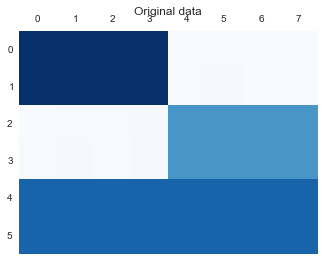

In [393]:
n, m = (6, 8)
X = .01 * np.random.rand(n, m)
X[0:2][:, 0:4] = 1 + .01 * np.random.random()
X[2:4][:, 4:8] = .6 + .01 * np.random.random()
X[4:6][:, 0:8] = .8 + .01 * np.random.random()

plt.matshow(X, cmap=plt.cm.Blues)
plt.title('Original data')
plt.grid()
plt.show()

In [396]:
k = 3
l = 2
U, S, V, V_tilde, rows_ind, error, reconstruction = overlapping_matrix_factorization_coclustering(X, k, l, num_iters=1000)

4.93270698689
4.6217054799
4.40415508568
4.13792726866
3.81278215275
3.47134935427
3.16123409076
2.88891008015
2.64203096214
2.41846897358
2.22340842939
2.06019711918
1.92770950745
1.82184349753
1.73755992968
1.67013016752
1.61561780537
1.57093324742
1.53371707619
1.50218367492
1.4749778684
1.45105946543
1.42961547736
1.40999513303
1.39166231153
1.37416088529
1.3570896057
1.34008420102
1.32280520609
1.30493071227
1.28615373573
1.26618425454
1.24475612594
1.22163899429
1.1966548475
1.16969800972
1.14075611808
1.1099282755
1.07743561826
1.04361966017
1.00892549506
0.97387018392
1.29238482293
1.27356237291
1.26953064139
1.26551888969
1.26185053191
1.2584100951
1.25511955075
1.25193937361
1.2488480072
1.2458321479
1.24288267215
1.23999288493
1.23715771145
1.2343732771
1.23163664893
1.22894564464
1.22629867043
1.22369457229
1.2211324957
1.21861175283
1.21613169833
1.21369161522
1.21129061254
1.20892753579
1.20660089085
1.20430878095
1.20204885589
1.19981827182
1.19761365932
1.19543109696
1.

KeyboardInterrupt: 

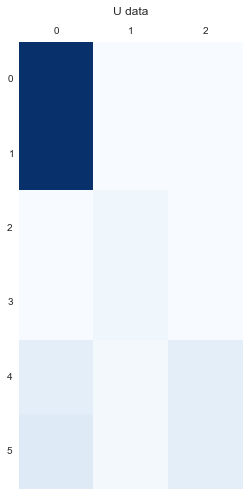

[[  6.74574912e+00   6.29597649e-04   5.14003159e-04]
 [  6.74626342e+00   2.27698441e-04   9.60069537e-04]
 [  6.05550100e-32   2.49117571e-01   3.73140762e-07]
 [  4.95292939e-32   2.48950066e-01   1.65320655e-07]
 [  6.65970042e-01   1.25618852e-01   6.83400338e-01]
 [  8.21750594e-01   1.42084792e-01   6.38745089e-01]]


array([[ 1.,  0.,  0.],
       [ 1.,  0.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  0.],
       [ 0.,  0.,  1.],
       [ 1.,  0.,  0.]])

In [395]:
plt.matshow(U, cmap=plt.cm.Blues)
plt.title('U data')
plt.grid()
plt.show()
print U

# Compute U binary
U_bin = np.zeros(U.shape)
rows_inds = np.argmax(U, axis=1)
for i in xrange(n):
     U_bin[i, rows_inds[i]] = 1
U_bin

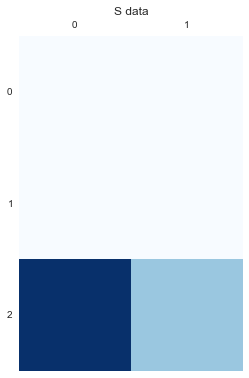

[[  8.59689547e-13   7.37136075e-12]
 [  1.44730373e-11   1.68918837e-11]
 [  2.81250558e-07   1.08244215e-07]]


In [382]:
plt.matshow(S, cmap=plt.cm.Blues)
plt.title('S data')
plt.grid()
plt.show()
print S

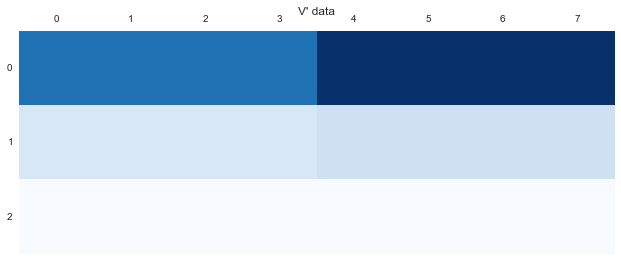

[[  1.16734160e+04   1.16510614e+04   1.16585384e+04   1.16716886e+04
    1.56144344e+04   1.56147401e+04   1.56147098e+04   1.56147456e+04]
 [  2.37949665e+03   2.38875598e+03   2.38041526e+03   2.39065885e+03
    3.19445486e+03   3.19507999e+03   3.19126294e+03   3.19339575e+03]
 [  1.64592871e-09   1.64591824e-09   1.64592554e-09   1.64592647e-09
    1.67712132e-10   1.63206596e-10   1.57658533e-10   1.60329619e-10]]


In [383]:
plt.matshow(V_tilde, cmap=plt.cm.Blues)
plt.title('V\' data')
plt.grid()
plt.show()

print V_tilde

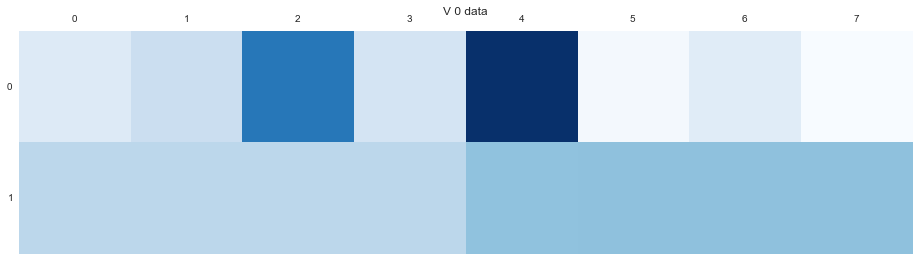

[[  2.09801981e+121   2.97500746e+121   7.51896195e+121   2.57876333e+121
    1.00164396e+122   1.11052803e+121   1.99241812e+121   9.50323259e+120]
 [  3.49732158e+121   3.48949980e+121   3.48594226e+121   3.49619011e+121
    4.66883718e+121   4.68029524e+121   4.67916063e+121   4.68050135e+121]]


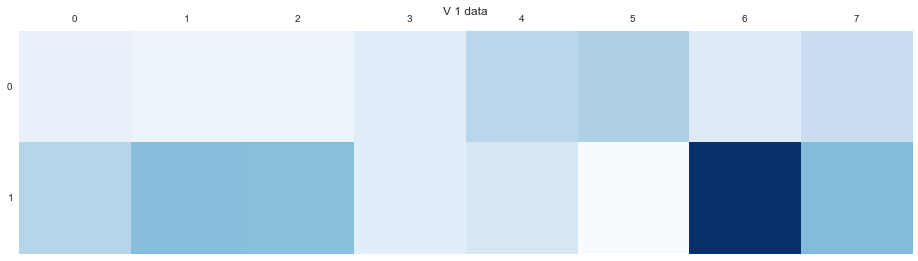

[[  1.14705323e+119   1.08041267e+119   1.07854612e+119   1.25314697e+119
    1.72521483e+119   1.81304335e+119   1.27676551e+119   1.57641489e+119]
 [  1.73892245e+119   2.11050242e+119   2.09335474e+119   1.23035257e+119
    1.38374494e+119   9.35126673e+118   3.67437385e+119   2.14379837e+119]]


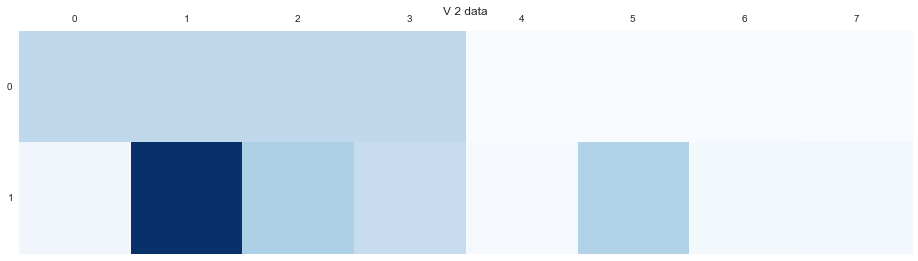

[[  1.97890625e+23   1.97838008e+23   1.97874678e+23   1.97879377e+23
    2.01623043e+22   1.96047257e+22   1.89532758e+22   1.92738995e+22]
 [  4.06913222e+22   6.82181203e+23   2.35103723e+23   1.77815683e+23
    2.64810556e+22   2.24672753e+23   2.97350732e+22   3.63218514e+22]]


In [384]:
for i in xrange(k):
    plt.matshow(V[i], cmap=plt.cm.Blues)
    plt.title('V %s data' % i)
    plt.grid()
    plt.show()
    
    print V[i]

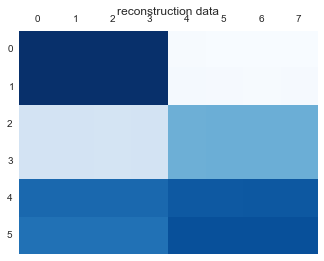

[[ 0.97979202  0.97843992  0.97914522  0.97924922  0.06875846  0.06590631
   0.06266     0.06425312]
 [ 0.97898045  0.97764386  0.97834519  0.97843079  0.07469919  0.07185737
   0.06867014  0.07023709]
 [ 0.22812447  0.22889723  0.22698628  0.22984272  0.5156344   0.5181138
   0.51781975  0.5181681 ]
 [ 0.22796957  0.22874225  0.22683122  0.22968811  0.51550383  0.51798358
   0.51768881  0.51803746]
 [ 0.7801104   0.78084997  0.78001957  0.78002859  0.83614671  0.83622909
   0.83874472  0.83786226]
 [ 0.7487201   0.74955124  0.74823001  0.74923283  0.86570883  0.86654747
   0.86840211  0.86785103]]


In [385]:
plt.matshow(reconstruction, cmap=plt.cm.Blues)
plt.title('reconstruction data')
plt.grid()
plt.show()

print reconstruction

In [306]:
-np.inf

-inf

In [68]:
a = np.array([[1,0,1], [1,1,1]])
np.linalg.det(a.T.dot(a))
a[[0, 1], 0]

array([1, 1])

In [136]:
x = np.eye(3)
is_any_clust_empty(x)

False

In [80]:
U = np.array([[ 0.91570654,  0.57800461,  1.23512502],
       [ 0.9118135 ,  0.57641111,  1.23000728],
       [ 0.82975406,  0.35305409,  0.72339393],
       [ 0.82842611,  0.35200641,  0.72380164],
       [ 1.82117839,  0.92417054,  1.93480911],
       [ 1.82117839,  0.92417054,  1.93480911]])

In [90]:
c = np.zeros((6,3))
print np.argmax(U, axis=1)
# for i in xrange(6):
#     c[i, np.argmax(U, axis=1)[i]] = 1
c[0:6, np.argmax(U, axis=1)]

[2 2 0 0 2 2]


array([[ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [229]:
np.linalg.det( np.eye(5).dot(np.eye(5).T) )

1.0

In [230]:
a = np.array([[0,1,0], [1,0,0], [1,0,0], [0,0,1], [0,0,1]])
a

array([[0, 1, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [377]:
%timeit
maxxx = -np.inf
for _ in xrange(10000000):
    x = np.random.rand(1)
    if x > maxxx:
        maxxx = x
maxxx

array([ 0.99999996])